In [1]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import torch
from torchvision.datasets import ImageNet
from torchvision import transforms
from torchvision.transforms import functional as F
import torch.nn.functional as batch
import torchvision
import torch.nn as nn

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from random import random
import torch.multiprocessing as mp
from torch.utils.data import random_split, DataLoader, Subset



# Weight decay


In [2]:
# Define the image limit
BATCH_SIZE = 64

TRAIN_SIZE = 500 * BATCH_SIZE
TEST_SIZE = 20 * BATCH_SIZE
LOSS_EVERY = 5
EPOCHS = 1
SPLIT = 'train'
WEIGHT_DECAY=5e-3
LEARNING_RATE = .00005

device = os.environ["DEVICE"]

DATA_DIR = os.environ['DATA_PATH']
CACHE_DIR = join(DATA_DIR, 'imagenet_inversion')
RESNET_SIZE = 224


class ResnetExtractor:
    def __init__(self):
        self.resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
        self.resnet50.eval().to(device)
        self.resnet_layer = self.resnet50.layers[2][0].downsample[0]

    def get_features(self, img):
        IMGNET_NORM = transforms.Compose([
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        imgnet_input = F.rgb_to_grayscale(IMGNET_NORM(img), num_output_channels=3).to(device).unsqueeze(0)

        def assign_features(module, input, output):
            nonlocal features
            features = output
        hook = self.resnet_layer.register_forward_hook(assign_features)
        
        with torch.no_grad():
            self.resnet50(imgnet_input)
        hook.remove()
        assert features is not None
        features = features.squeeze(0)
        return features


class CachedImageNet(ImageNet):
    def __init__(self, root, split, version='0.1'):
        TRANSFORM = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
        super().__init__(root=root, split=split, transform=TRANSFORM)
        self.cache_dir = os.path.join(CACHE_DIR, version, split)

        # Create cache directory if it doesn't exist
        os.makedirs(self.cache_dir, exist_ok=True)
        self.resnet_extractor = None

    def get_extractor(self):
        if self.resnet_extractor is None:
            self.resnet_extractor = ResnetExtractor()
        return self.resnet_extractor

    def _get_cache_path(self, index):
        """Get the path for the cached feature."""
        return os.path.join(self.cache_dir, f'feature_{index}.pt')

    def __getitem__(self, index):
        # Load the image and label
        img, object_class = super().__getitem__(index)

        cache_path = self._get_cache_path(index)
        features = None
        if not os.path.exists(cache_path):
            # # Image transformations
            # if os.path.exists(cache_path):
            #     saved_features = torch.load(cache_path).to(device)
            #     assert torch.equal(features,saved_features)
            features = self.get_extractor().get_features(img)
            self.save_atomic(features, cache_path)
        else:
            features = torch.load(cache_path).to(device)

        target = F.rgb_to_grayscale(img, num_output_channels=1)
        return features, target
    def save_atomic(self, value, name):
        tmp_name = name + '.tmp' + str(random())
        torch.save(value, tmp_name)
        os.replace(tmp_name, name)
# Example feature extractor: compute mean/std per channel



# Set the start method to 'spawn'
mp.set_start_method('spawn', force=True)
# Initialize CachedImageNet
train_dataset = CachedImageNet(
    root=join(DATA_DIR, 'imagenet'),
    split=SPLIT,
    version='1.1'
)


assert(len(train_dataset) >= TRAIN_SIZE + TEST_SIZE)

# Define the split sizes

# Split the dataset within the limit
train_subset_indices = list(range(TRAIN_SIZE))  # Indices for the training subset
test_subset_indices = list(range(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE))  # Indices for the test subset

# Create the subsets
train_subset = Subset(train_dataset, train_subset_indices)
test_subset = Subset(train_dataset, test_subset_indices)

# Define the batch size

# Create DataLoaders for train and test
train_loader = DataLoader(
    dataset=train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle can be enabled based on your training needs
    num_workers=0
)

test_loader = DataLoader(
    dataset=test_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No need to shuffle test data
    num_workers=0
)

print(f"Train loader contains {len(train_loader)} batches.")
print(f"Test loader contains {len(test_loader)} batches.")


Train loader contains 500 batches.
Test loader contains 20 batches.


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


torch.Size([64, 1, 224, 224])


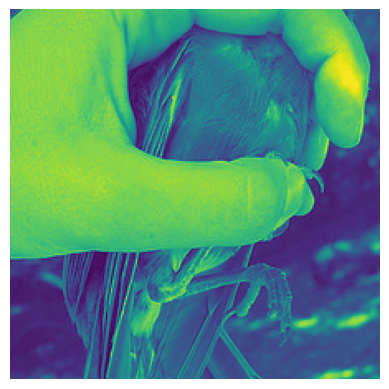

In [3]:
# Get a batch from the DataLoader
def show_image(img_tensor):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
    plt.imshow(img)
    plt.axis('off')
    plt.show()


data_iter = iter(train_loader)  # Replace `train_loader` with your DataLoader
features, targets = next(data_iter)
print(targets.shape)
show_image(targets[0])  # Show the first image in the batch

In [4]:
class UpsampleModel(nn.Module):
    def __init__(self):
        super(UpsampleModel, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=768,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(768),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=768, out_channels=512,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=512, out_channels=384,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(384),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(
                in_channels=384, out_channels=256,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(256, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(32, 16, kernel_size=1, padding=0),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(16, 1, kernel_size=1, padding=0)
        )

    def forward(self, x):
        return self.model(x)



# Example usage:
model = UpsampleModel()


input_tensor = torch.randn(1, 1024, 14, 14)  # Batch size = 1
output_tensor = model(input_tensor)
assert output_tensor.shape == torch.Size([1,1,224,224])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
params = count_parameters(model)
print("Total parametrs: ", params)
print("Params in samples : ", params / (224*224))

Total parametrs:  24511329
Params in samples :  488.5070352359694


In [5]:
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

T_max = len(train_loader) * EPOCHS  # Total number of batches across all epochs

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max)

In [6]:
import torch


# Training loop
model.train()
model.to(device)
running_loss = 0.0
losses = []
for epoch in range(EPOCHS):
    for i, (features, target) in enumerate(train_loader):
        features = features.to(device)  # Move to device
        target = target.to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Step the scheduler after each batch
        scheduler.step()

        # Log the running loss
        running_loss += loss.item()
        if i % LOSS_EVERY == LOSS_EVERY - 1:
            avg_loss = running_loss / LOSS_EVERY
            print(f"Epoch {epoch+1}, Batch {i+1}, LR: {scheduler.get_last_lr()[0]:.6f}, Loss: {avg_loss:.4f}")
            losses.append(avg_loss)
            running_loss = 0.0


Epoch 1, Batch 5, LR: 0.000050, Loss: 0.7481


Epoch 1, Batch 10, LR: 0.000050, Loss: 0.6417


Epoch 1, Batch 15, LR: 0.000050, Loss: 0.6179


Epoch 1, Batch 20, LR: 0.000050, Loss: 0.6046


Epoch 1, Batch 25, LR: 0.000050, Loss: 0.6017


Epoch 1, Batch 30, LR: 0.000050, Loss: 0.5982


Epoch 1, Batch 35, LR: 0.000049, Loss: 0.5917


Epoch 1, Batch 40, LR: 0.000049, Loss: 0.5913


Epoch 1, Batch 45, LR: 0.000049, Loss: 0.5874


Epoch 1, Batch 50, LR: 0.000049, Loss: 0.5854


Epoch 1, Batch 55, LR: 0.000049, Loss: 0.5829


Epoch 1, Batch 60, LR: 0.000048, Loss: 0.5928


Epoch 1, Batch 65, LR: 0.000048, Loss: 0.5899


Epoch 1, Batch 70, LR: 0.000048, Loss: 0.5889


Epoch 1, Batch 75, LR: 0.000047, Loss: 0.5798


Epoch 1, Batch 80, LR: 0.000047, Loss: 0.5739


Epoch 1, Batch 85, LR: 0.000047, Loss: 0.5847


Epoch 1, Batch 90, LR: 0.000046, Loss: 0.5843


Epoch 1, Batch 95, LR: 0.000046, Loss: 0.5718


Epoch 1, Batch 100, LR: 0.000045, Loss: 0.5799


Epoch 1, Batch 105, LR: 0.000045, Loss: 0.5825


Epoch 1, Batch 110, LR: 0.000044, Loss: 0.5842


Epoch 1, Batch 115, LR: 0.000044, Loss: 0.5783


Epoch 1, Batch 120, LR: 0.000043, Loss: 0.5799


Epoch 1, Batch 125, LR: 0.000043, Loss: 0.5822


Epoch 1, Batch 130, LR: 0.000042, Loss: 0.5812


Epoch 1, Batch 135, LR: 0.000042, Loss: 0.5781


Epoch 1, Batch 140, LR: 0.000041, Loss: 0.5820


Epoch 1, Batch 145, LR: 0.000040, Loss: 0.5787


Epoch 1, Batch 150, LR: 0.000040, Loss: 0.5824


Epoch 1, Batch 155, LR: 0.000039, Loss: 0.5757


Epoch 1, Batch 160, LR: 0.000038, Loss: 0.5758


Epoch 1, Batch 165, LR: 0.000038, Loss: 0.5759


Epoch 1, Batch 170, LR: 0.000037, Loss: 0.5816


Epoch 1, Batch 175, LR: 0.000036, Loss: 0.5710


Epoch 1, Batch 180, LR: 0.000036, Loss: 0.5754


Epoch 1, Batch 185, LR: 0.000035, Loss: 0.5777


Epoch 1, Batch 190, LR: 0.000034, Loss: 0.5761


Epoch 1, Batch 195, LR: 0.000033, Loss: 0.5811


Epoch 1, Batch 200, LR: 0.000033, Loss: 0.5863


Epoch 1, Batch 205, LR: 0.000032, Loss: 0.5727


Epoch 1, Batch 210, LR: 0.000031, Loss: 0.5848


Epoch 1, Batch 215, LR: 0.000030, Loss: 0.5851


Epoch 1, Batch 220, LR: 0.000030, Loss: 0.5755


Epoch 1, Batch 225, LR: 0.000029, Loss: 0.5851


Epoch 1, Batch 230, LR: 0.000028, Loss: 0.5742


Epoch 1, Batch 235, LR: 0.000027, Loss: 0.5751


Epoch 1, Batch 240, LR: 0.000027, Loss: 0.5802


Epoch 1, Batch 245, LR: 0.000026, Loss: 0.5801


Epoch 1, Batch 250, LR: 0.000025, Loss: 0.5726


Epoch 1, Batch 255, LR: 0.000024, Loss: 0.5735


Epoch 1, Batch 260, LR: 0.000023, Loss: 0.5740


Epoch 1, Batch 265, LR: 0.000023, Loss: 0.5782


Epoch 1, Batch 270, LR: 0.000022, Loss: 0.5841


Epoch 1, Batch 275, LR: 0.000021, Loss: 0.5709


Epoch 1, Batch 280, LR: 0.000020, Loss: 0.5775


Epoch 1, Batch 285, LR: 0.000020, Loss: 0.5693


Epoch 1, Batch 290, LR: 0.000019, Loss: 0.5705


Epoch 1, Batch 295, LR: 0.000018, Loss: 0.5703


Epoch 1, Batch 300, LR: 0.000017, Loss: 0.5747


Epoch 1, Batch 305, LR: 0.000017, Loss: 0.5755


Epoch 1, Batch 310, LR: 0.000016, Loss: 0.5747


Epoch 1, Batch 315, LR: 0.000015, Loss: 0.5831


Epoch 1, Batch 320, LR: 0.000014, Loss: 0.5836


Epoch 1, Batch 325, LR: 0.000014, Loss: 0.5877


Epoch 1, Batch 330, LR: 0.000013, Loss: 0.5717


Epoch 1, Batch 335, LR: 0.000012, Loss: 0.5791


Epoch 1, Batch 340, LR: 0.000012, Loss: 0.5791


Epoch 1, Batch 345, LR: 0.000011, Loss: 0.5784


Epoch 1, Batch 350, LR: 0.000010, Loss: 0.5790


Epoch 1, Batch 355, LR: 0.000010, Loss: 0.5799


Epoch 1, Batch 360, LR: 0.000009, Loss: 0.5758


Epoch 1, Batch 365, LR: 0.000008, Loss: 0.5763


Epoch 1, Batch 370, LR: 0.000008, Loss: 0.5799


Epoch 1, Batch 375, LR: 0.000007, Loss: 0.5768


Epoch 1, Batch 380, LR: 0.000007, Loss: 0.5736


Epoch 1, Batch 385, LR: 0.000006, Loss: 0.5759


Epoch 1, Batch 390, LR: 0.000006, Loss: 0.5740


Epoch 1, Batch 395, LR: 0.000005, Loss: 0.5703


Epoch 1, Batch 400, LR: 0.000005, Loss: 0.5818


Epoch 1, Batch 405, LR: 0.000004, Loss: 0.5737


Epoch 1, Batch 410, LR: 0.000004, Loss: 0.5750


Epoch 1, Batch 415, LR: 0.000003, Loss: 0.5742


Epoch 1, Batch 420, LR: 0.000003, Loss: 0.5759


Epoch 1, Batch 425, LR: 0.000003, Loss: 0.5790


Epoch 1, Batch 430, LR: 0.000002, Loss: 0.5723


Epoch 1, Batch 435, LR: 0.000002, Loss: 0.5720


Epoch 1, Batch 440, LR: 0.000002, Loss: 0.5689


Epoch 1, Batch 445, LR: 0.000001, Loss: 0.5685


Epoch 1, Batch 450, LR: 0.000001, Loss: 0.5756


Epoch 1, Batch 455, LR: 0.000001, Loss: 0.5687


Epoch 1, Batch 460, LR: 0.000001, Loss: 0.5805


Epoch 1, Batch 465, LR: 0.000001, Loss: 0.5781


Epoch 1, Batch 470, LR: 0.000000, Loss: 0.5796


Epoch 1, Batch 475, LR: 0.000000, Loss: 0.5656


Epoch 1, Batch 480, LR: 0.000000, Loss: 0.5773


Epoch 1, Batch 485, LR: 0.000000, Loss: 0.5756


Epoch 1, Batch 490, LR: 0.000000, Loss: 0.5752


Epoch 1, Batch 495, LR: 0.000000, Loss: 0.5774


Epoch 1, Batch 500, LR: 0.000000, Loss: 0.5750


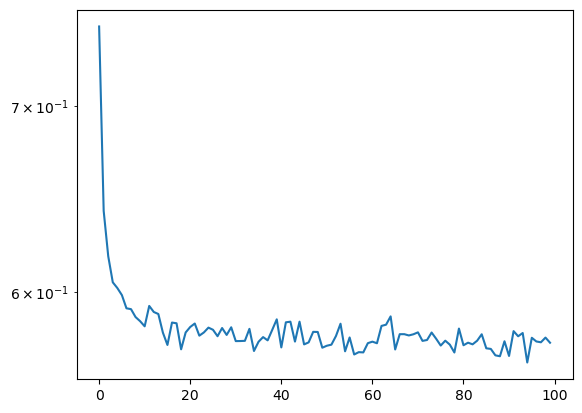

In [7]:
# Plot losses
plt.plot(losses)
plt.yscale('log')
# set maximum y to 

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:02<00:43,  2.27s/it]

 10%|█         | 2/20 [00:04<00:41,  2.33s/it]

 15%|█▌        | 3/20 [00:06<00:39,  2.32s/it]

 20%|██        | 4/20 [00:09<00:36,  2.27s/it]

 25%|██▌       | 5/20 [00:11<00:34,  2.27s/it]

 30%|███       | 6/20 [00:13<00:31,  2.22s/it]

 35%|███▌      | 7/20 [00:15<00:29,  2.25s/it]

 40%|████      | 8/20 [00:18<00:27,  2.28s/it]

 45%|████▌     | 9/20 [00:20<00:25,  2.32s/it]

 50%|█████     | 10/20 [00:23<00:23,  2.38s/it]

 55%|█████▌    | 11/20 [00:25<00:21,  2.44s/it]

 60%|██████    | 12/20 [00:27<00:19,  2.39s/it]

 65%|██████▌   | 13/20 [00:30<00:16,  2.36s/it]

 70%|███████   | 14/20 [00:32<00:13,  2.33s/it]

 75%|███████▌  | 15/20 [00:34<00:11,  2.32s/it]

 80%|████████  | 16/20 [00:36<00:08,  2.23s/it]

 85%|████████▌ | 17/20 [00:39<00:06,  2.22s/it]

 90%|█████████ | 18/20 [00:41<00:04,  2.27s/it]

 95%|█████████▌| 19/20 [00:43<00:02,  2.22s/it]

100%|██████████| 20/20 [00:45<00:00,  2.15s/it]

100%|██████████| 20/20 [00:45<00:00,  2.27s/it]

Test Loss: 0.5629


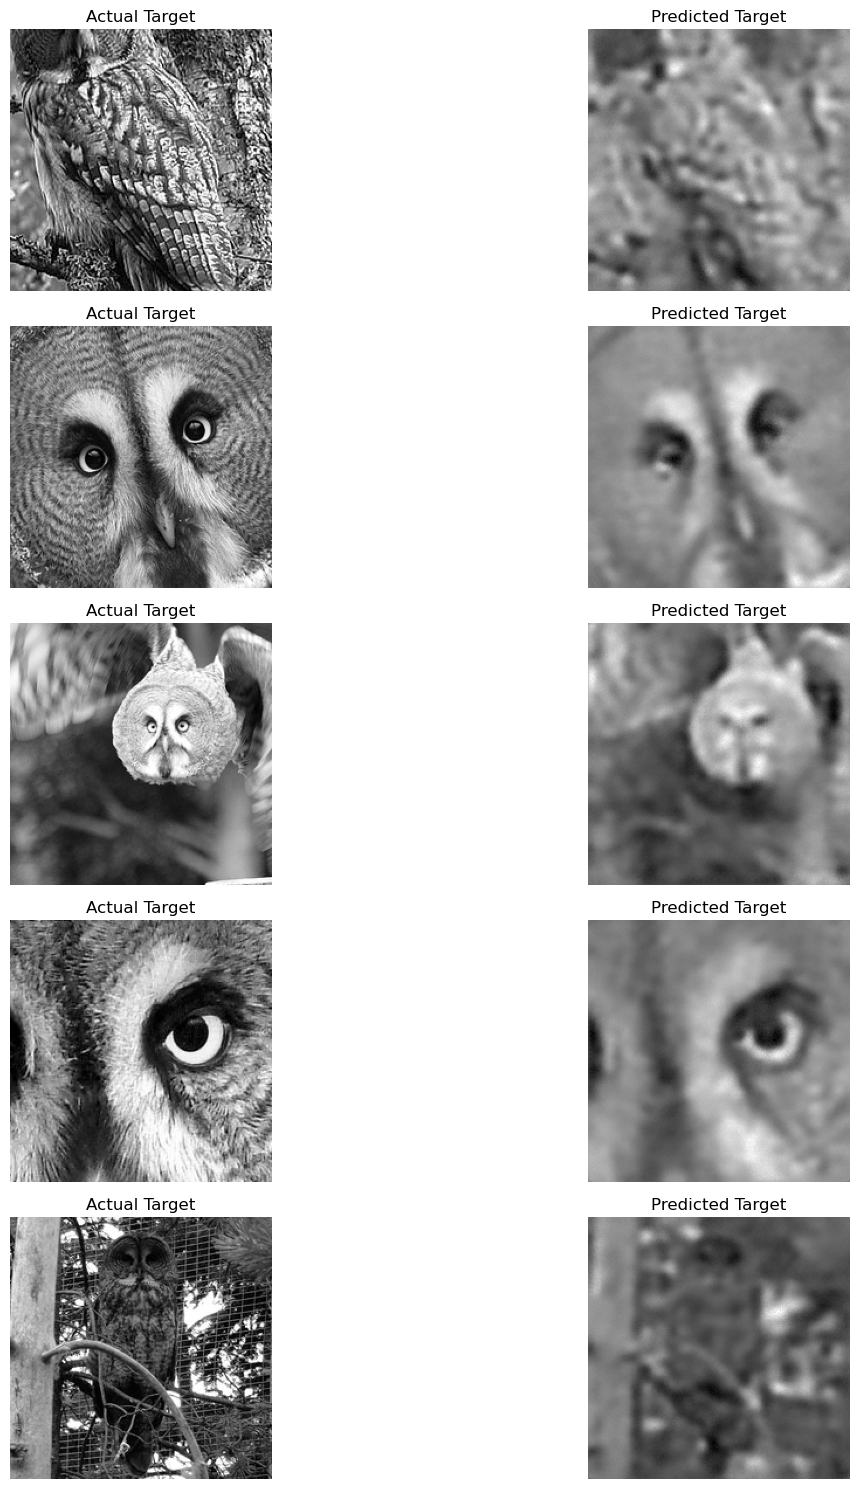

In [8]:
import matplotlib.pyplot as plt

def evaluate_partial_model(model, test_loader, device, max_batches=10_000):
    model.eval()
    test_loss = 0.0
    all_targets = []
    all_predictions = []

    num_batches = min(max_batches, len(test_loader)) 
    processed_batches = 0

    with torch.no_grad():
        for features, target in tqdm(test_loader):
            if processed_batches >= num_batches:
                break

            features = features.to(device)
            target = target.to(device)

            # Predict
            predictions = model(features)

            loss = criterion(predictions, target)
            test_loss += loss.item()

            # Store for plotting
            all_targets.append(target.cpu())
            all_predictions.append(predictions.cpu())

            processed_batches += 1

    test_loss /= processed_batches
    all_targets = torch.cat(all_targets, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)

    return test_loss, all_targets, all_predictions

# Evaluate on the first 10% of the test dataset
test_loss_partial, partial_targets, partial_predictions = evaluate_partial_model(model, test_loader, device)
print(f"Test Loss: {test_loss_partial:.4f}")

def plot_examples(targets, predictions, num_examples=5):
    plt.figure(figsize=(15, num_examples * 3))
    for i in range(num_examples):
        # Plot the actual target
        plt.subplot(num_examples, 2, 2 * i + 1)
        plt.imshow(targets[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Actual Target")
        plt.axis('off')

        # Plot the predicted target
        plt.subplot(num_examples, 2, 2 * i + 2)
        plt.imshow(predictions[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Predicted Target")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot Examples
num_examples = 5  # Number of examples to visualize
plot_examples(partial_targets[:num_examples].cpu().numpy(), partial_predictions[:num_examples].cpu().numpy())


In [9]:
print(partial_predictions.min(), partial_predictions.max())
print(partial_targets.min(), partial_targets.max())

tensor(-6.5902) tensor(6.5483)
tensor(0.) tensor(0.9999)


In [10]:
name_extra = os.environ['SLURM_JOB_ID'] if 'SLURM_JOB_ID' in os.environ else ''
name = join(os.environ['MODELS_PATH'], "mlp" + name_extra + ".pt")
torch.save(model, name)
print("Model saved to ", name)

Model saved to  /scratch/izar/vanousek/cs-433-project/models/mlp2490421.pt
